In [24]:
!pip install -q datasets soundfile speechbrain requests
!pip install -q transformers
!pip install -q --upgrade accelerate

In [1]:
from pathlib import Path
import multiprocessing
import requests

from datasets import load_dataset, Audio, Dataset, DatasetDict

import multiprocessing
from pathlib import Path
from collections import Counter

import pyewts
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
from datasets import DatasetDict, Audio, concatenate_datasets
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio as display_audio

In [8]:
n_cpu = multiprocessing.cpu_count()-10; n_cpu
data_path = Path.cwd() / "data"
audio_path = data_path / "audio"
audio_path.mkdir(parents=True, exist_ok=True)

In [9]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

## Load the dataset

In [5]:
dataset_name = "openpecha/tts-training-filtered"
dataset = load_dataset(dataset_name)
dataset

DatasetDict({
    train: Dataset({
        features: ['file_name', 'uni', 'url', 'sentence', 'label', 'speaker_id', 'duration'],
        num_rows: 534753
    })
    test: Dataset({
        features: ['file_name', 'uni', 'url', 'sentence', 'label', 'speaker_id', 'duration'],
        num_rows: 133689
    })
})

## Filter Dataset

### Ignore Long Audio
Some of the examples in the dataset are apparently longer than the maximum input length the model can handle (600 tokens), so we should remove those from the dataset. In fact, to allow for larger batch sizes we'll remove anything over 200 tokens.

In [6]:
dataset = concatenate_datasets([dataset["train"], dataset["test"]])

In [10]:
def compute_tokens_len(item):
    tokens = processor.tokenizer.tokenize(item["sentence"])
    item["tokens_len"] = len(tokens)
    return item

dataset = dataset.map(compute_tokens_len, num_proc=n_cpu)

Map (num_proc=54):   0%|          | 0/668442 [00:00<?, ? examples/s]

In [11]:
dataset[0]["tokens_len"]

9

In [13]:
def plot_token_len_histogram(token_lengths):
    # Plotting the histogram
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.hist(token_lengths, bins=20, edgecolor='black')  # Create a histogram with 10 bins
    
    # Adding titles and labels
    plt.title('Histogram of Token Lengths')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    
    # Show the chart
    plt.show()

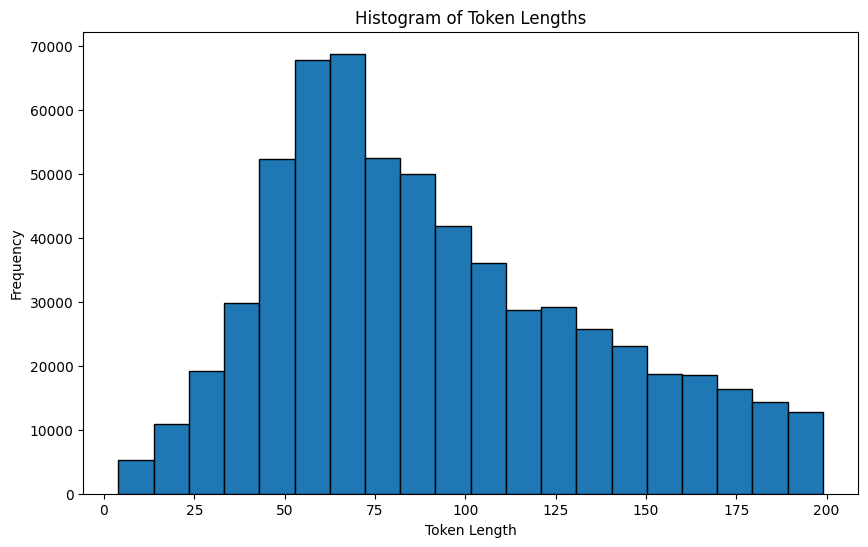

In [14]:
plot_token_len_histogram(dataset["tokens_len"])

In [15]:
dataset = dataset.filter(lambda x: x["tokens_len"]<200, num_proc=n_cpu)
len(dataset)

Filter (num_proc=54):   0%|          | 0/621899 [00:00<?, ? examples/s]

621899

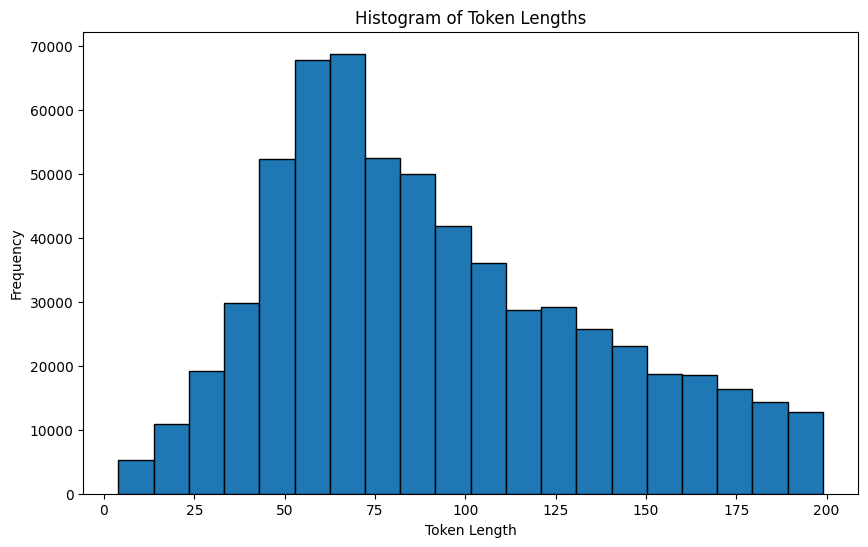

In [16]:
plot_token_len_histogram(dataset["tokens_len"])

### Balance out Departments

In [19]:
def plot_department_dist(dataset):
    c = Counter(dataset["label"])
    print(c)
    labels = list(c.keys())
    sizes =  list(c.values()) # Percentages or absolute values
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', "#ffff99"]  # Optional colors
    
    # Create the pie chart
    plt.figure(figsize=(4, 4))  # Set the figure size
    plt.pie(
        sizes, 
        labels=labels, 
        colors=colors, 
        autopct='%1.1f%%',  # Show percentages with 1 decimal
        shadow=True,        # Add shadow effect
        startangle=140      # Rotate the start angle
    )
    
    # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.axis('equal')
    
    # Show the chart
    plt.title('Department')
    plt.show()

Counter({'STT_NS': 214021, 'STT_AB': 166009, 'STT_NW': 87645, 'STT_HS': 83814, 'STT_PC': 70410})


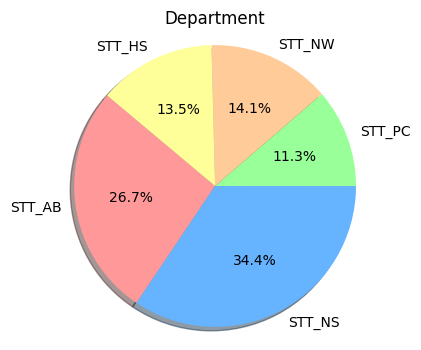

In [20]:
plot_department_dist(dataset)

In [30]:
def get_balance_dataset(dataset, total, seed=42):
    ab_dataset = dataset.filter(lambda x: x["label"] == "STT_AB", num_proc=n_cpu).shuffle(seed=seed)
    nw_dataset = dataset.filter(lambda x: x["label"] == "STT_NW", num_proc=n_cpu).shuffle(seed=seed)
    hs_dataset = dataset.filter(lambda x: x["label"] == "STT_HS", num_proc=n_cpu).shuffle(seed=seed)
    pc_dataset = dataset.filter(lambda x: x["label"] == "STT_PC", num_proc=n_cpu).shuffle(seed=seed)
    ns_dataset = dataset.filter(lambda x: x["label"] == "STT_NS", num_proc=n_cpu).shuffle(seed=seed)

    ab_dataset = ab_dataset.select(range(total//5))
    nw_dataset = nw_dataset.select(range(total//5))
    hs_dataset = hs_dataset.select(range(total//5))
    pc_dataset = pc_dataset.select(range(total//5))
    ns_dataset = ns_dataset.select(range(total//5))
    print(len(ns_dataset))

    ab_dataset = ab_dataset.train_test_split(test_size=0.2, seed=42)
    nw_dataset = nw_dataset.train_test_split(test_size=0.2, seed=42)
    hs_dataset = hs_dataset.train_test_split(test_size=0.2, seed=42)
    pc_dataset = pc_dataset.train_test_split(test_size=0.2, seed=42)
    ns_dataset = ns_dataset.train_test_split(test_size=0.2, seed=42)


    dataset = DatasetDict({
        "train": concatenate_datasets([ab_dataset["train"], nw_dataset["train"], hs_dataset["train"], pc_dataset["train"], ns_dataset["train"]]),
        "test": concatenate_datasets([ab_dataset["test"], nw_dataset["test"], hs_dataset["test"], pc_dataset["test"], ns_dataset["test"]])
    })

    return dataset

In [31]:
balanced_dataset = get_balance_dataset(dataset, total=150000)
len(balanced_dataset)

30000


2

Counter({'STT_AB': 30000, 'STT_NW': 30000, 'STT_HS': 30000, 'STT_PC': 30000, 'STT_NS': 30000})


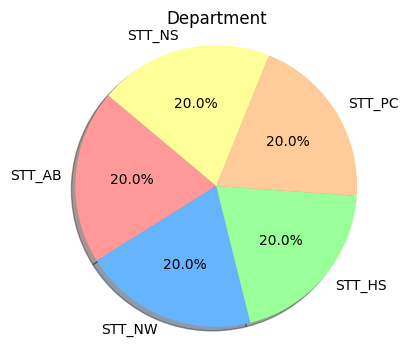

In [32]:
plot_department_dist(concatenate_datasets([balanced_dataset["train"], balanced_dataset["test"]]))

In [23]:
def download_image(url, save_path):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Check for any HTTP errors
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
    except requests.exceptions.RequestException as e:
        raise e

def prepare_audio_file(item):
    file_name = f"{item['file_name']}.wav"
    local_path = audio_path / file_name
    if not local_path.is_file():
        if item["file_name"].startswith("STT_AB"):
            url = f"https://d38pmlk0v88drf.cloudfront.net/AB_wav16k_cleaned/{file_name}"
        else:
            url = item["url"]
        try:
            download_image(url, local_path)
        except:
            local_path = None

    item["path"] = str(local_path) if local_path else local_path
    del item["file_name"]
    del item["url"]

    return item

In [5]:
# sample_ds = DatasetDict()

# sample_ds["train"] = ds["train"].select(range(8)).map(prepare_audio_file, num_proc=n_cpu-1)
# sample_ds["test"] = ds["test"].select(range(2)).map(prepare_audio_file, num_proc=n_cpu)
# print(len(sample_ds["train"]), len(sample_ds["test"]))
# sample_ds = sample_ds.filter(lambda x: x["path"], num_proc=n_cpu)
# print(len(sample_ds["train"]), len(sample_ds["test"]))

# dataset_path = data_path / "tts-training-processed-sample"
# sample_ds.save_to_disk(dataset_path)

<!-- loaded_ds = DatasetDict.load_from_disk(dataset_path)
loaded_ds -->

In [6]:
# xs = ds["test"].filter(lambda x: x["file_name"].startswith("STT_AB"), num_proc=n_cpu)

In [7]:
# xs[100]

## Download All Audio files

In [33]:
ds = balanced_dataset

In [34]:
all_ds = DatasetDict()

all_ds["train"] = ds["train"].map(prepare_audio_file, num_proc=n_cpu)
all_ds["test"] = ds["test"].map(prepare_audio_file, num_proc=n_cpu)
print(len(all_ds["train"]), len(all_ds["test"]))
all_ds = all_ds.filter(lambda x: x["path"] != 'None', num_proc=n_cpu)
print(len(all_ds["train"]), len(all_ds["test"]))

dataset_path = data_path / "tts-training-processed"
all_ds.save_to_disk(dataset_path)

Map (num_proc=54):   0%|          | 0/120000 [00:00<?, ? examples/s]

Process ForkPoolWorker-481:
Process ForkPoolWorker-457:
Process ForkPoolWorker-465:
Process ForkPoolWorker-458:
Process ForkPoolWorker-452:
Process ForkPoolWorker-471:
Process ForkPoolWorker-461:
Process ForkPoolWorker-464:
Process ForkPoolWorker-469:
Process ForkPoolWorker-483:
Process ForkPoolWorker-479:
Process ForkPoolWorker-455:
Process ForkPoolWorker-478:
Process ForkPoolWorker-453:
Process ForkPoolWorker-472:
Process ForkPoolWorker-476:
Process ForkPoolWorker-475:
Process ForkPoolWorker-456:
Process ForkPoolWorker-460:
Process ForkPoolWorker-477:
Process ForkPoolWorker-470:
Process ForkPoolWorker-459:
Process ForkPoolWorker-473:
Process ForkPoolWorker-474:
Process ForkPoolWorker-462:
Process ForkPoolWorker-463:
Process ForkPoolWorker-454:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-466:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceb